# Generate Image Stack Without Speckle Noise 
This will be achieved by creating an image stack with speckle noiseless data by applying morphological filters.  I will follow the following [tutorial](http://archive.is/ZKIvI) on doing this. 

# Imports

In [1]:
import numpy as np
import scipy.io 
import pandas as  pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

# Data Manipulation

In [3]:
def invertImages(stack):
    [slices,w,l] = np.shape(stack)
    invertedImages = np.zeros([slices,l,w])
    numSlices = np.shape(stack)[0]
    for sliceIndex in xrange(numSlices):        
        currentImage = np.fliplr(np.flipud(stack[sliceIndex].T))
        invertedImages[sliceIndex]= currentImage        
    return invertedImages    

# Visualization Functions

In [4]:
def drawSingleImage(stack):
    plt.figure()
    plt.imshow(stack)

In [5]:
def drawSlice(stack,sliceIndex):
    plt.figure()
    plt.imshow(stack[sliceIndex])

In [6]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='jet')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

# Mask Functions

In [7]:
def maskImageStack(stack,mask):    
    maskedImages = np.zeros(np.shape(stack))
    numSlices = np.shape(stack)[0]
    for sliceIndex in xrange(numSlices):
        currentImage = stack[sliceIndex]
        maskedImages[sliceIndex]= np.multiply(currentImage,mask)
    
    return maskedImages    

# Data visualization Functions
- [3D Plotting](https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/)

In [8]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

import  plotly.plotly  as py
import plotly.graph_objs as go

In [9]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage

In [10]:
def make_mesh(image, threshold=-300, step_size=1):
    print "Transposing surface"
    p = image.transpose(2,1,0)
    
    print "Calculating surface"
    verts, faces = measure.marching_cubes(p, threshold) 
    #verts, faces, normals, values = measure.marching_cubes_lewiner(p, 0.0)
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print "Drawing"
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print "Drawing"
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    print 'generating poly3d'
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    print 'finished generating poly3d'
    face_color = [1, 1, 0.9]
    print 'adding some colour'
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    print 'setting limits'
    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    print 'adding some colour'
    ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    print 'showing'
    plt.show()
    print 'finished'

In [11]:
def myplotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print "Drawing"
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap="Portland",
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)


# Main Work

## Data Info

In [16]:
thStack = np.load('./sandboxScripts/thStack.npy')

In [17]:
[d,w,l] = np.shape(thStack)
print('The stack has %d slices with the dimension of [%d x %d]'%(d,w,l))

The stack has 180 slices with the dimension of [760 x 766]


## Morphological Filtering
We will use the following:
- Erosion and Dilation to remove tiny features 
- Masking



In [103]:
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage import filters

In [72]:
#Standardize the pixel values
def make_veinmask(img,erodeFilter,dilationFilter, display=False):
    # erodeFilter: is a 2x2 array eg [3,3]
    # dilationFilter: is a 2x2 array eg [8,8]
    
    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

#     eroded = morphology.erosion(img,np.ones([3,3]))
#     dilation = morphology.dilation(eroded,np.ones([8,8]))
    eroded = morphology.erosion(img,np.ones(erodeFilter))
    dilation = morphology.dilation(eroded,np.ones(dilationFilter))

#     labels = measure.label(dilation) # Different labels are displayed in different colors
#     label_vals = np.unique(labels)
#     regions = measure.regionprops(labels)
#     good_labels = []
#     for prop in regions:
#         B = prop.bbox
#         if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
#             good_labels.append(prop.label)
#     mask = np.ndarray([row_size,col_size],dtype=np.int8)
#     mask[:] = 0

#     #
#     #  After just the lungs are left, we do another large dilation
#     #  in order to fill in and out the lung mask 
#     #
#     for N in good_labels:
#         mask = mask + np.where(labels==N,1,0)
#     mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
      
    if (display):
        fig, ax = plt.subplots(1, 4, figsize=[20, 20])
        ax[0].set_title("Original")
        ax[0].imshow(img, cmap='gray')
        ax[0].axis('off')
        ax[1].set_title("Eroded Only Image")
        ax[1].imshow(eroded, cmap='gray')
        ax[1].axis('off')
        ax[2].set_title("Erode and Dilated Image")
        ax[2].imshow(dilation, cmap='gray')
        ax[2].axis('off')
        ax[3].set_title("Removed Elements")
        ax[3].imshow(np.subtract(img,dilation), cmap='gray')
        ax[3].axis('off')
        plt.show()

#     if (display):
#         fig, ax = plt.subplots(3, 2, figsize=[12, 12])
#         ax[0, 0].set_title("Original")
#         ax[0, 0].imshow(img, cmap='gray')
#         ax[0, 0].axis('off')
#         ax[0, 1].set_title("Threshold")
#         ax[0, 1].imshow(thresh_img, cmap='gray')
#         ax[0, 1].axis('off')
#         ax[1, 0].set_title("After Erosion and Dilation")
#         ax[1, 0].imshow(dilation, cmap='gray')
#         ax[1, 0].axis('off')
#         ax[1, 1].set_title("Color Labels")
#         ax[1, 1].imshow(labels)
#         ax[1, 1].axis('off')
#         ax[2, 0].set_title("Final Mask")
#         ax[2, 0].imshow(mask, cmap='gray')
#         ax[2, 0].axis('off')
#         ax[2, 1].set_title("Apply Mask on Original")
#         ax[2, 1].imshow(mask*img, cmap='gray')
#         ax[2, 1].axis('off')
        
#         plt.show()
    return np.array(dilation)

In [113]:
def drawMultipleMasks(img,erodeFilter,dilationFilter, display=False):
    [d,w,l] = np.shape(img)
    dilatedStack = np.zeros(np.shape(img))
    
    if(d>3):
        print('Too many to display make the image depth to 3 or less')
        return dilatedStack
    else:
        for dIndex in xrange(d):
            dilatedStack[dIndex,:,:] = make_veinmask(img[dIndex],erodeFilter,dilationFilter, display=True)
    return dilatedStack            

In [115]:
def drawMultipleMasksWithFilter(img,erodeFilter,dilationFilter, display=False,numNeighbours=3):
    [d,w,l] = np.shape(img)
    dilatedStack = np.zeros(np.shape(img))
    
    if(d>3):
        print('Too many to display make the image depth to 3 or less')
        return dilatedStack
    else:
        for dIndex in xrange(d):
            dilatedStack[dIndex,:,:] = make_veinmask(applyMedianFilter(img[dIndex],numNeighbours),erodeFilter,dilationFilter, display=True)
    return dilatedStack            

In [104]:
def applyMedianFilter(img,numNeighbours):
    medianImage = filters.rank.median(img,morphology.disk(numNeighbours))
    return medianImage

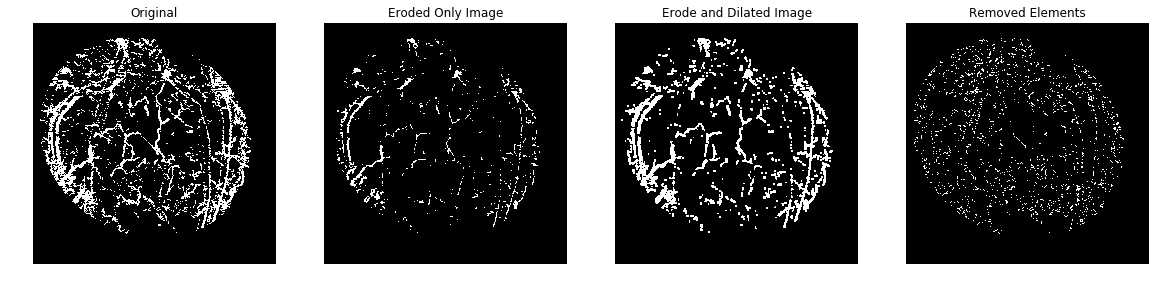

In [73]:
erodeFilter = [4,4]
dilationFilter = [5,5]
img = thStack[100]
diltedImg = make_veinmask(img,erodeFilter,dilationFilter, display=True)  

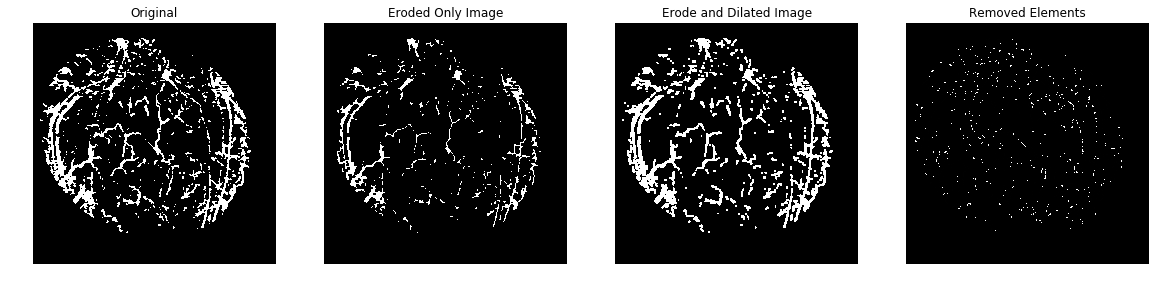

In [116]:
diltedImg = make_veinmask(applyMedianFilter(img,numNeighbours=3),erodeFilter,dilationFilter, display=True)  

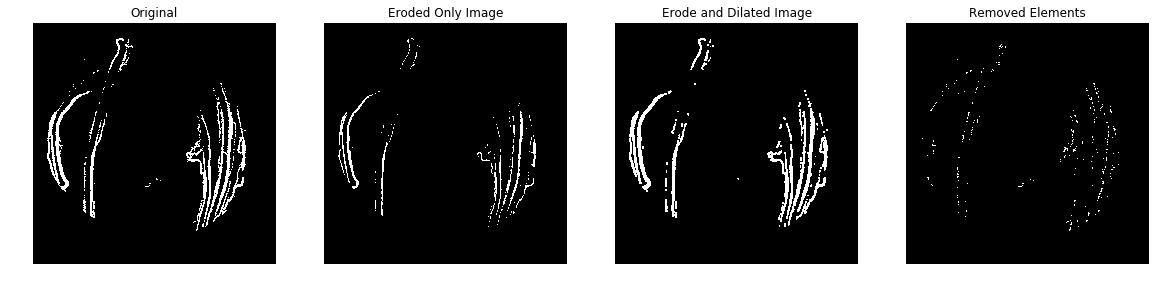

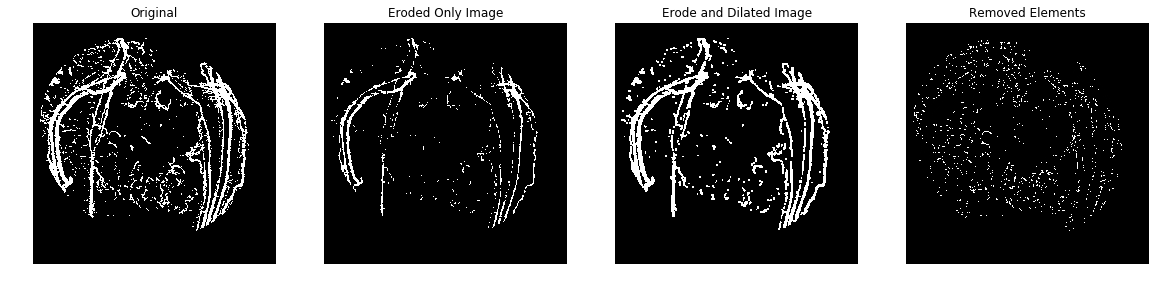

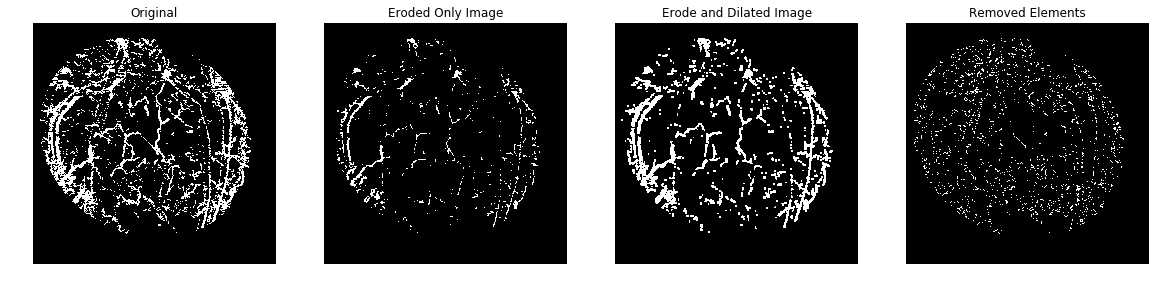

In [102]:
erodeFilter = [4,4]
dilationFilter = [5,5]
imgStack = thStack[[10,50,100],:,:]
dilatedStack = drawMultipleMasks(imgStack,erodeFilter,dilationFilter, display=False)

There are still small speckle like noise in the final image.  Let us apply a median filter to remove this.

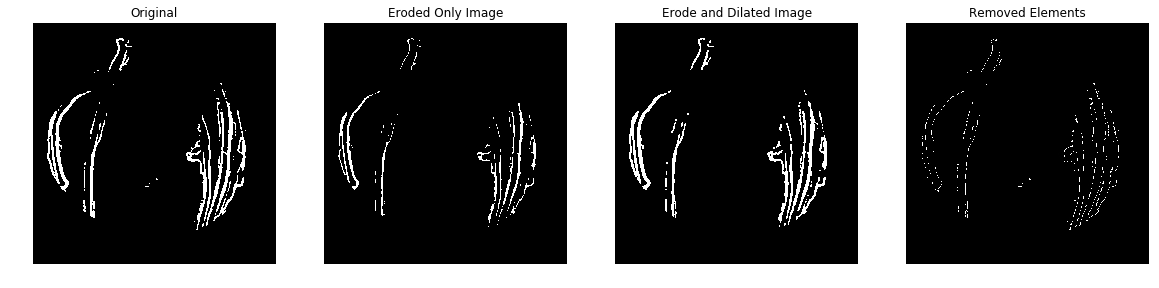

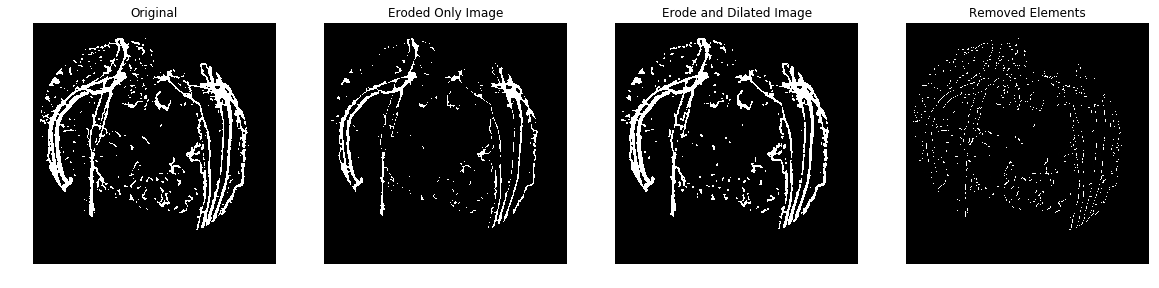

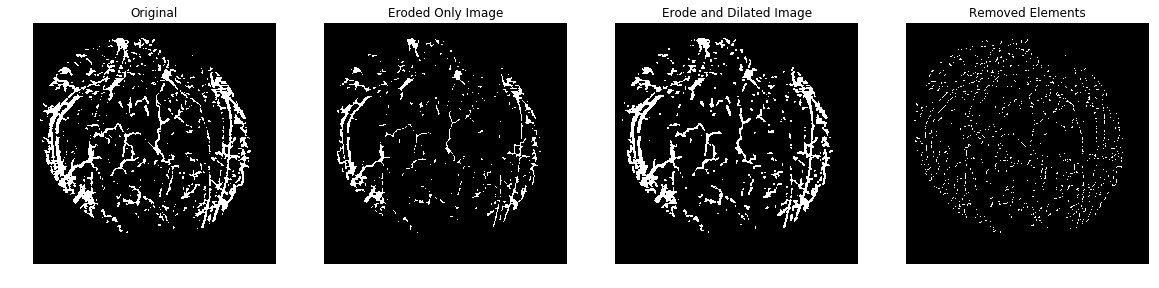

In [131]:
erodeFilter = [4,4]
dilationFilter = [4,4]
imgStack = thStack[[10,50,100],:,:]
dilatedStack = drawMultipleMasksWithFilter(imgStack,erodeFilter,dilationFilter, display=False)

This looks a lot better.  Just in case we can make two stacks of images one with the morphological filter and one with the added median filter mixed into it.

# Apply Morphological Filters

In [118]:
morphStack = np.zeros(np.shape(thStack))
[d,w,l] = np.shape(morphStack)

erodeFilter = [4,4]
dilationFilter = [5,5]

for dIndex in xrange(d):
    morphStack[dIndex,:,:] = make_veinmask(thStack[dIndex],erodeFilter,dilationFilter, display=False)

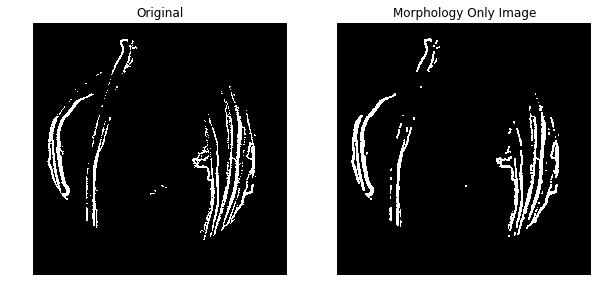

In [124]:
fig, ax = plt.subplots(1, 2, figsize=[10, 10])
ax[0].set_title("Original")
ax[0].imshow(thStack[10], cmap='gray')
ax[0].axis('off')
ax[1].set_title("Morphology Only Image")
ax[1].imshow(morphStack[10], cmap='gray')
ax[1].axis('off')
plt.show()

This is what we expected so let us save the file

In [125]:
np.save('./sandboxScripts/thStackMorphologyApplied.npy',morphStack)

# Apply Median and Morphology Filters

In [132]:
medMorphStack = np.zeros(np.shape(thStack))
[d,w,l] = np.shape(medMorphStack)

erodeFilter = [4,4]
dilationFilter = [4,4]

for dIndex in xrange(d):    
    medMorphStack[dIndex,:,:] = make_veinmask(applyMedianFilter(thStack[dIndex],numNeighbours=3),erodeFilter,dilationFilter, display=False)

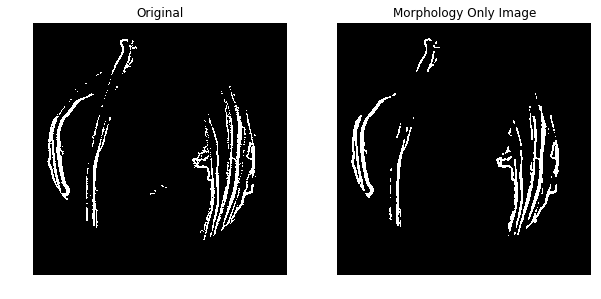

In [134]:
fig, ax = plt.subplots(1, 2, figsize=[10, 10])
ax[0].set_title("Original")
ax[0].imshow(thStack[10], cmap='gray')
ax[0].axis('off')
ax[1].set_title("Morphology Only Image")
ax[1].imshow(medMorphStack[10], cmap='gray')
ax[1].axis('off')
plt.show()

Again this is what we expected so now let us save this into a file.

In [133]:
np.save('./sandboxScripts/thStackMedianMorphologyApplied.npy',medMorphStack)